In [45]:
# Necessary Imports
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
import matplotlib.pyplot as plt
import os
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from sklearn.model_selection import train_test_split

In [2]:
# Define the root directory containing all user directories
root_directory = "C:/Users/vkuma/School/Rice/DeepLearning/FinalProject/Balabit_MouseDynamicsData/training_files"

# Initialize a list to store all trajectories from all files
all_trajectories = []

# Iterate over all directories and files
for subdir, _, files in os.walk(root_directory):
    for filename in files:
        file_path = os.path.join(subdir, filename)
        
        # Read the data from the file
        with open(file_path, 'r') as f:
            lines = f.readlines()

        # Skip the header and process the rest of the data
        data_values = []
        state_values = []

        for line in lines[1:]:  # Skip the header line
            parts = line.strip().split(',')  # Split the line by commas
            x = float(parts[4])  # x-coordinate
            y = float(parts[5])  # y-coordinate
            client_timestamp = float(parts[1])  # client timestamp
            state = parts[3]  # State (e.g., "Move", "Pressed")
            
            data_values.append([x, y, client_timestamp])
            state_values.append(state)

        # Convert to NumPy arrays
        data = np.array(data_values)
        state_values = np.array(state_values)

        # Trajectory extraction for this file
        trajectories = []
        current_trajectory = []

        for i in range(len(data)):
            if state_values[i] == "Move":  # Only include points with state == "Move"
                current_trajectory.append(data[i])
            else:
                # If the state changes from "Move", save the current trajectory
                if current_trajectory:
                    trajectories.append(np.array(current_trajectory))
                    current_trajectory = []

        # Save the last trajectory if it exists
        if current_trajectory:
            trajectories.append(np.array(current_trajectory))

        # Add trajectories from this file to the global list
        all_trajectories.extend(trajectories)

        # Print summary for this file
        print(f"Processed {file_path}: Extracted {len(trajectories)} trajectories.")

# Display total results across all files
print(f"Total trajectories extracted from all files: {len(all_trajectories)}")

Processed C:/Users/vkuma/School/Rice/DeepLearning/FinalProject/Balabit_MouseDynamicsData/training_files\user12\session_2144641057: Extracted 1173 trajectories.
Processed C:/Users/vkuma/School/Rice/DeepLearning/FinalProject/Balabit_MouseDynamicsData/training_files\user12\session_5265929106: Extracted 1413 trajectories.
Processed C:/Users/vkuma/School/Rice/DeepLearning/FinalProject/Balabit_MouseDynamicsData/training_files\user12\session_5815391283: Extracted 2311 trajectories.
Processed C:/Users/vkuma/School/Rice/DeepLearning/FinalProject/Balabit_MouseDynamicsData/training_files\user12\session_7409188284: Extracted 1287 trajectories.
Processed C:/Users/vkuma/School/Rice/DeepLearning/FinalProject/Balabit_MouseDynamicsData/training_files\user12\session_8872593360: Extracted 1589 trajectories.
Processed C:/Users/vkuma/School/Rice/DeepLearning/FinalProject/Balabit_MouseDynamicsData/training_files\user12\session_9031593624: Extracted 1800 trajectories.
Processed C:/Users/vkuma/School/Rice/Dee

In [ ]:
# Filter trajectories for length 50+ and trim to 50 points
filtered_trajectories = []

for traj in all_trajectories:
    if len(traj) >= 25:  # Check if the trajectory has at least 50 points
        x_values = traj[:, 0]
        y_values = traj[:, 1]
        # Ensure all points are in a reasonable range for normalization
        if np.all(x_values < 1000) and np.all(y_values < 1000):
            filtered_trajectories.append(traj[:25])  # Trim to exactly 50 points

# Print the results
print(f"Number of filtered trajectories (length 25+ and all x, y < 1000): {len(filtered_trajectories)}")

Number of filtered trajectories (length 25+ and all x, y < 1000): 15498


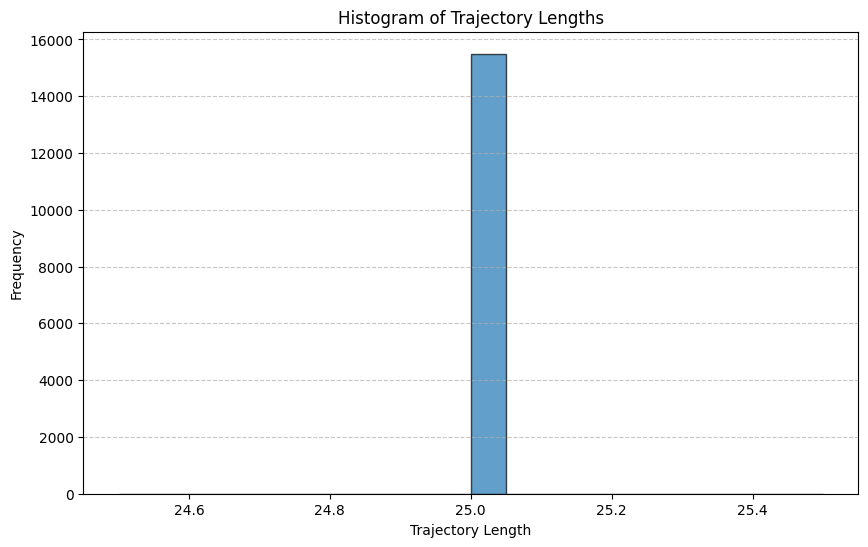

In [4]:
# Calculate the lengths of all trajectories
trajectory_lengths = [len(traj) for traj in filtered_trajectories]

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(trajectory_lengths, bins=20, edgecolor='black', alpha=0.7)
plt.title("Histogram of Trajectory Lengths")
plt.xlabel("Trajectory Length")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [28]:
# Rescale each trajectory to start at (0, 0, 0)
rescaled_trajectories = []

for traj in filtered_trajectories:
    start_point = traj[0]  # Starting point (x, y, t)
    rescaled_traj = traj - start_point  # Subtract the starting point from all points
    rescaled_trajectories.append(rescaled_traj)

# Convert to a NumPy array for training
rescaled_trajectories = np.array(rescaled_trajectories)

# Calculate the maximum values for x and y
max_x = np.max([np.max(np.abs(rescaled_trajectories[i][:, 0])) for i in range(len(rescaled_trajectories))])
max_y = np.max([np.max(np.abs(rescaled_trajectories[i][:, 1])) for i in range(len(rescaled_trajectories))])

# Scale each trajectory's x and y values between [-1, 1]
for i in range(len(rescaled_trajectories)):
    # Scale the x (first column) and y (second column) of each trajectory
    rescaled_trajectories[i][:, 0] /= max_x  # Scale x by max_x
    rescaled_trajectories[i][:, 1] /= max_y  # Scale y by max_y

In [46]:
# Compute step sizes and time differences
step_sizes = []
time_differences = []

for traj in rescaled_trajectories:
    dx = np.diff(traj[:, 0])
    dy = np.diff(traj[:, 1])
    dt = np.diff(traj[:, 2])

    steps = np.sqrt(dx**2 + dy**2)
    step_sizes.extend(steps)
    time_differences.extend(dt)

# Convert to NumPy arrays
step_sizes = np.array(step_sizes)
time_differences = np.array(time_differences)

In [47]:
# First split: 70% training, 30% temporary (val + test)
X_train, X_temp, y_train, y_temp = train_test_split(
    step_sizes, time_differences, test_size=0.3, random_state=42
)

# Second split: 50% validation, 50% test from the temporary set
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

# Print sizes for confirmation
print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

Training set size: 260366
Validation set size: 55793
Test set size: 55793


In [48]:
# Define the Dataset class
class TrajectoryDataset(Dataset):
    def __init__(self, features, targets):
        self.features = torch.tensor(features, dtype=torch.float32).unsqueeze(1)
        self.targets = torch.tensor(targets, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

# Create datasets
train_dataset = TrajectoryDataset(X_train, y_train)
val_dataset = TrajectoryDataset(X_val, y_val)
test_dataset = TrajectoryDataset(X_test, y_test)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [49]:
import torch.nn as nn
import torch.optim as optim

class StepToTimeModel(nn.Module):
    def __init__(self):
        super(StepToTimeModel, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(1, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.network(x)

# Instantiate the model
model = StepToTimeModel()

In [52]:
# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [53]:
# Training loop with validation
num_epochs = 100
for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_train_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()

    # Validation phase
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_val_loss += loss.item()

    # Print epoch progress
    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {running_train_loss / len(train_loader):.4f}, "
          f"Validation Loss: {running_val_loss / len(val_loader):.4f}")


Epoch 1/100, Train Loss: 70.4076, Validation Loss: 358.8600
Epoch 2/100, Train Loss: 69.9061, Validation Loss: 358.8752
Epoch 3/100, Train Loss: 69.1844, Validation Loss: 363.2313
Epoch 4/100, Train Loss: 69.6712, Validation Loss: 359.1458
Epoch 5/100, Train Loss: 69.2617, Validation Loss: 359.4364
Epoch 6/100, Train Loss: 69.3258, Validation Loss: 358.8715
Epoch 7/100, Train Loss: 68.9698, Validation Loss: 361.6862
Epoch 8/100, Train Loss: 69.5877, Validation Loss: 359.0093


KeyboardInterrupt: 